# Load from database

<a href="https://colab.research.google.com/github/kirubarajan/roft/blob/master/annotation/analysis/research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fsspec gcsfs

     |████████████████████████████████| 125 kB 5.2 MB/s 
     |████████████████████████████████| 1.3 MB 35.1 MB/s 
     |████████████████████████████████| 271 kB 43.8 MB/s 
     |████████████████████████████████| 160 kB 66.3 MB/s 


In [2]:
import json
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATABASE_DUMP_FILE = 'gs://roft_buckups/2021_09_23.json'

In [3]:
from google.colab import auth
auth.authenticate_user()

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [5]:
with tf.io.gfile.GFile(DATABASE_DUMP_FILE, 'r') as f:
    lines = f.readlines()
    db = json.loads(lines[1])

def get_df(sql_model='core.annotation'):
    df = pd.DataFrame(db)
    df = df[df.model == sql_model]
    
    if 'date' in df.columns.values:
        df = df.set_index('date')

    return pd.json_normalize(df.fields).assign(pk=df.pk.values)

In [6]:
df = pd.DataFrame(db)
print(set(df["model"].tolist()))

{'contenttypes.contenttype', 'sessions.session', 'auth.user', 'core.prompt', 'core.timestamp', 'core.annotation', 'core.decodingstrategy', 'core.profile', 'admin.logentry', 'core.feedbackoption', 'core.generation', 'auth.permission', 'core.system', 'core.dataset', 'core.playlist'}


### Load all the tables

In [7]:
annotation_df = get_df()
profile_df = get_df('core.profile')
generation_df = get_df('core.generation')
prompt_df = get_df('core.prompt')
playlist_df = get_df('core.playlist')
decodingstrategy_df = get_df('core.decodingstrategy')
user_df = get_df('auth.user')

### Modify column names to avoid duplicates across tables.

In [8]:
prompt_df = prompt_df.rename(columns={"body": "prompt_body"})
generation_df = generation_df.rename(columns={"body": "gen_body"})
decodingstrategy_df = decodingstrategy_df.rename(
    columns={"name": "dec_strat", "value": "dec_strat_value"})
annotation_df["date"] = pd.to_datetime(annotation_df["date"])

### Merge all the relevant tables together.

In [9]:
gen_to_playlist = {}
for idx, row in playlist_df.iterrows():
  shortname = row["shortname"]
  version = row["version"]
  generations = row["generations"]
  for gen_id in generations:
    gen_to_playlist[gen_id] = (shortname, version)

In [10]:
full_df = annotation_df.join(generation_df.set_index('pk'), on='generation')
full_df = full_df.join(prompt_df.set_index('pk'), 'prompt')
full_df = full_df.join(decodingstrategy_df.set_index('pk'), 'decoding_strategy')

In [11]:
playlist_names = [] 
playlist_versions = []
for idx, row in full_df.iterrows():
  gen_id = row["generation"]
  playlist_info = gen_to_playlist[gen_id]
  playlist_names.append(playlist_info[0])
  playlist_versions.append(playlist_info[1])
full_df["playlist_name"] = playlist_names
full_df["playlist_version"] = playlist_versions

In [12]:
full_df

,date,annotator,generation,playlist,boundary,points,attention_check,reason,pk,system,prompt,decoding_strategy,gen_body,prompt_body,num_sentences,dataset,prompt_index,dec_strat,dec_strat_value,playlist_name,playlist_version
0,2021-06-12 22:17:41.178000+00:00,2,909,1,3,0,False,[],1,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.2
1,2021-06-12 23:08:41.084000+00:00,4,909,1,3,0,False,[contradicts_knowledge],2,gpt2,932,1,Jack and Max was a fine company to join on suc...,"It's lonely work, killing the future._SEP_Jack...",5,1,1653,top-p,0.4,Short Stories,0.2
2,2021-06-21 19:31:08.098000+00:00,139,18298,3,0,0,False,[contradicts_knowledge],3,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
3,2021-06-23 19:35:29.878000+00:00,182,18298,3,0,0,False,[-2311780724603632545],4,ctrl,13345,1,,"""Speech on Foreign Policy"" by President Ronald...",10,8,714,top-p,0.4,Presidential Speeches,0.2
4,2021-06-25 18:56:37.169000+00:00,272,12621,-1,7,0,False,[irrelevant],5,gpt2-xl,7668,4,The Mayor has been in office for more than two...,"USUALLY, when a mayor dismisses people from th...",9,3,1098,top-p,0.2,New York Times,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14893,2021-09-22 03:30:27.564000+00:00,3587,18844,-1,0,0,False,[],19383,gpt2-xl,13891,1,Melt the remaining 1 tablespoon of butter over...,HOW TO MAKE: Twice-Baked Potatoes With Mushroo...,3,9,2685,top-p,0.4,Recipes,0.2
14894,2021-09-22 03:31:41.153000+00:00,3587,16536,-1,2,0,False,[],19384,gpt2-xl,11583,6,A wide variety of industries have reported suc...,American industry is pulling back on scientifi...,7,5,3918,top-p,0.5,New York Times,0.1
14895,2021-09-22 04:22:40.997000+00:00,3588,4979,5,0,0,False,"[-516607735864282965, grammar]",19385,gpt2,5033,1,,Hey Mom sorry I won't be able to come again._S...,10,2,3307,top-p,0.4,Short Stories,0.2
14896,2021-09-22 04:24:09.504000+00:00,3588,8004,5,6,0,False,[contradicts_knowledge],19386,gpt2-xl,2143,1,"""Its okay,"" says Andrew, ""we're not here for y...","Four friends, two boys and two girls, sit arou...",9,1,3097,top-p,0.4,Short Stories,0.2


# Filtering annotations for users who have agreed to have their data analyzed

In [13]:
SURVEY_RESPONSES_FILE = 'gs://roft_buckups/521_responses.csv'
survey_df = pd.read_csv(SURVEY_RESPONSES_FILE)
survey_filter_df = survey_df[survey_df["Do you agree for the data being collected on this form along with any annotations you make on the RoFT website to be used in an anonymized, aggregated way for research on students' ability to detect machine-generated text? Your answer on this question will not affect your grade."] == 'No']

# all the users who GAVE US PERMISSION
users_filter_df = user_df[~user_df.email.isin(survey_filter_df["Email Address"].values)]

# all the profiles that GAVE US PERMISSION
profiles_filter_df = profile_df[profile_df.user.isin(users_filter_df.pk)]

full_df = full_df[full_df.annotator.isin(profiles_filter_df.pk)]

In [ ]:
# TODO: Filter out our own profiles

# Analysis

## Mean points

In [14]:
def analyze_per_playlist():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  for playlist in playlist_names:
    df = full_df[(full_df["playlist_name"]==playlist) & (full_df["playlist_version"]=="0.2")]

    info = {"playlist": playlist,
            "mean score": np.mean(df["points"]),
            "median score": np.median(df["points"]),
            "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
            "num_annotations": len(df)
    }
    info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_playlist()

,playlist,mean score,median score,fraction_nonzero,num_annotations
0,Recipes,1.958728,0.0,0.484188,5597
1,Presidential Speeches,1.846250,1.0,0.516250,2400
2,Short Stories,1.900160,0.0,0.494400,3125
3,New York Times,1.719173,0.0,0.485095,2952


In [15]:
def analyze_per_decoding_strat():
  info_to_return = []
  playlist_names = set(playlist_df["shortname"].tolist())
  for playlist in playlist_names:
    for top_p_value in [0.0, 0.4, 1.0]:
      df = full_df[(full_df["dec_strat"]=="top-p") &
                  (full_df["dec_strat_value"]==top_p_value) &
                  (full_df["playlist_name"]==playlist)]

      if len(df) > 0:
        info = {"p-value": top_p_value,
                "playlist": playlist,
                "mean score": np.mean(df["points"]),
                "median score": np.median(df["points"]),
                "fraction_nonzero": len(df[df["points"] > 0]) / len(df),
                "num_annotations": len(df),
        }
        info_to_return.append(info)
  return pd.DataFrame(info_to_return)

analyze_per_decoding_strat() #TODO: Split up by model here

,p-value,playlist,mean score,median score,fraction_nonzero,num_annotations
0,0.4,Recipes,1.958728,0.0,0.484188,5597
1,0.4,Presidential Speeches,1.846250,1.0,0.516250,2400
2,0.0,Short Stories,1.551887,0.0,0.466981,212
3,0.4,Short Stories,1.920847,0.0,0.493125,2691
4,1.0,Short Stories,1.981982,2.0,0.536036,222
5,0.0,New York Times,1.519569,0.0,0.455969,1022
6,0.4,New York Times,1.583062,0.0,0.456026,921
7,1.0,New York Times,2.045590,1.0,0.541130,1009


#Mean Points for only the first 10 annotations from each annotator


In [27]:
full_df.sort_values(['date']).groupby('annotator').head(10).groupby('annotator').points.mean()

annotator
2       0.000000
4       2.666667
139     0.000000
182     0.000000
272     1.500000
          ...   
3363    4.250000
3551    2.500000
3572    0.000000
3587    1.000000
3588    1.333333
Name: points, Length: 440, dtype: float64

In [ ]:
full_df.columns

In [ ]:
[0.0, 0.4, 1.0]

## Annotator skill

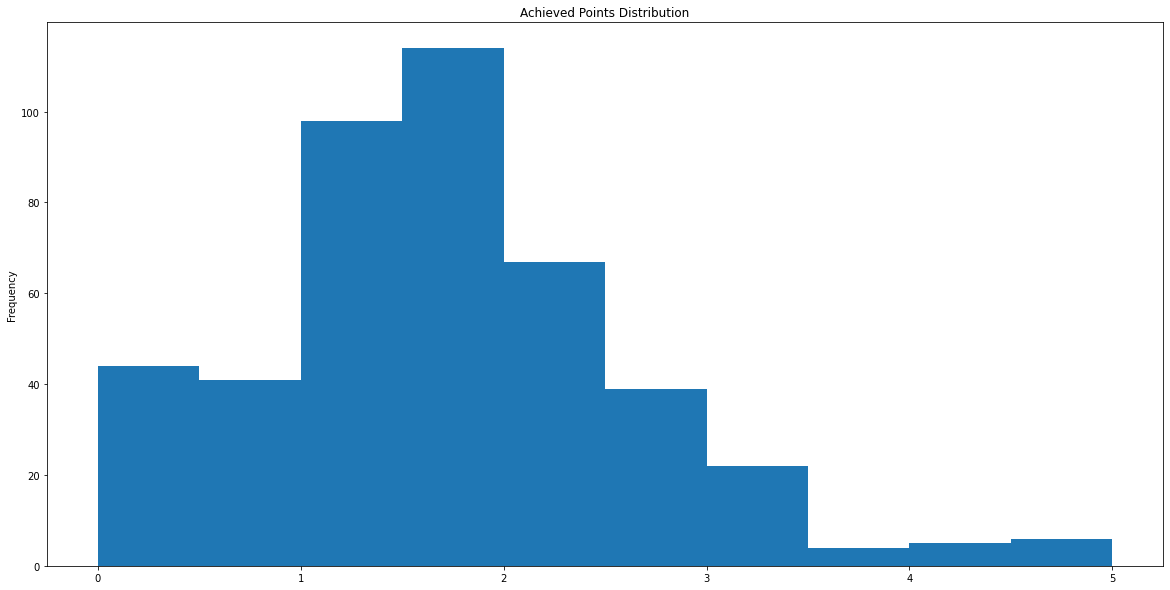

In [23]:
annotation_df.groupby('annotator').points.mean().plot.hist(
    figsize=(20, 10),
    title='Achieved Points Distribution'
)

Of the annotators who did at least K annotations, plot their mean score over time

In [19]:
df = annotation_df.groupby('annotator').count()


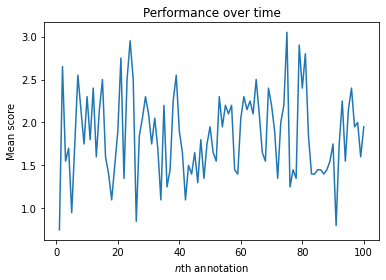

In [20]:
def analyze_progress(k=50):
  """Analyze whether annotators improve in aggregate over k annotations."""
  all_score_series = []
  annotators = df[df["pk"] > k].reset_index()["annotator"].tolist()
  for annotator in annotators:
    annotations = annotation_df[annotation_df["annotator"] == annotator]
    score_series = annotations.sort_values("date")["points"][:k].tolist()
    all_score_series.append(score_series)

  return np.array(all_score_series)

k = 100
s = analyze_progress(k)
data = np.array(s)
data = np.mean(data, axis=0)
plt.plot(range(1, k+1), data)
plt.ylabel("Mean score")
plt.xlabel("$n$th annotation")
plt.title("Performance over time")
plt.show()

### Inter-annotator agreement

For every pair of annotators who annotated the same generaton, what fraction guessed the same boundary?

In [27]:
annotations_per_gen = annotation_df.groupby('generation')
# 
num_annotations_per_gen = annotations_per_gen.points.count()


In [28]:
def analyze_fraction_agreements():
  generation_ids = set(annotation_df["generation"].tolist())
  annotations_per_gen = annotation_df.groupby('generation')

  overall_num_annotations = 0
  overall_num_agreements = 0

  x = annotations_per_gen.boundary.value_counts()
  for idx, generation in enumerate(generation_ids):
    chosen_boundaries = x[generation]
    chosen_boundaries = {k: chosen_boundaries[k] for k in chosen_boundaries.keys()}
    
    total_annotations = sum(chosen_boundaries.values())
    if total_annotations > 1:
      total_agreements = sum(v for v in chosen_boundaries.values() if v > 1)

      overall_num_annotations += total_annotations
      overall_num_agreements += total_agreements

  print("Out of {} total annotations on generations with >1 annotation, {} were in agreement with another annotation on the true boundary position. That is {}".format(
      overall_num_annotations, overall_num_agreements, overall_num_agreements/overall_num_annotations
  ))
analyze_fraction_agreements()

# TODO: Figure out what the baseline of random guessing would be,

Out of 13915 total annotations on generations with >1 annotation, 6275 were in agreement with another annotation on the true boundary position. That is 0.4509522098454905


In [29]:
user_df[user_df["pk"] == 2697]

,password,last_login,is_superuser,username,first_name,last_name,email,is_staff,is_active,date_joined,groups,user_permissions,pk
2696,pbkdf2_sha256$180000$hp9YfmKe5tvv$eoUGPhGpjKz7...,2021-09-08T21:35:40.375Z,False,xyc,,,,False,True,2021-09-08T20:58:58.557Z,[],[],2697


## Profile Statistics

In [30]:
profile_df.is_temporary.mean()

0.8973373593192424